In [9]:
# Imports

In [11]:
import sys, os
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

from src.utils.preprocess import get_data_generators, load_isic_data, compute_class_weights_from_names
from src.model.model import build_model, compile_model, fine_tune_model, get_gradcam_heatmap

In [13]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.data_adapters.py_dataset_adapter")

In [15]:
# Configuration variables

In [17]:
DATA_DIR = '../data/ISIC2018_Task3_Training_Input'
CSV_FILE = '../data/ISIC2018_Task3_Training_GroundTruth.csv'  # ensure path / filename matches your repo
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

In [19]:
# load & inspect dataset distribution

Class names: ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
Total images: 10015


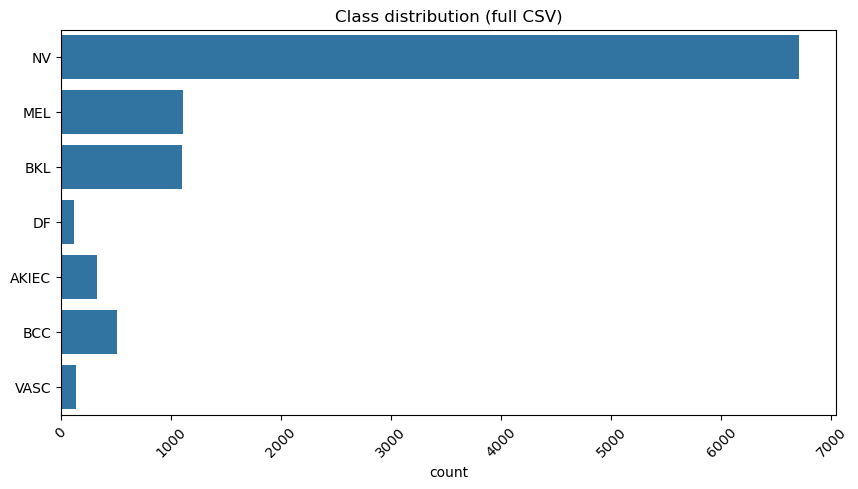

In [21]:
image_paths, label_indices, label_names, class_names = load_isic_data(DATA_DIR, CSV_FILE)
print(f'Class names: {class_names}')
print('Total images:', len(image_paths))

plt.figure(figsize=(10,5))
sns.countplot(label_names)
plt.xticks(rotation=45)
plt.title('Class distribution (full CSV)')
plt.show()

In [23]:
train_generator, val_generator, class_names = get_data_generators(DATA_DIR, CSV_FILE, img_size=IMG_SIZE, batch_size=BATCH_SIZE, subset_frac=None, seed=SEED)

Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


In [25]:
# check generator mapping

In [27]:
print('Train class indices:', train_generator.class_indices)
print('Num train steps per epoch:', train_generator.samples // BATCH_SIZE)
print('Num val steps:', val_generator.samples // BATCH_SIZE)

Train class indices: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6}
Num train steps per epoch: 250
Num val steps: 62


In [29]:
# Compute class weights using the fixed snippet

In [31]:
inv_map = {v:k for k,v in train_generator.class_indices.items()}

y_train_names = []
steps_per_epoch = int(np.ceil(train_generator.samples / train_generator.batch_size))

for i, (_, y_batch) in enumerate(train_generator):
    indices = np.argmax(y_batch, axis=1)
    y_train_names.extend([inv_map[i] for i in indices])
    if i + 1 >= steps_per_epoch:
        break

y_train_names = y_train_names[:train_generator.samples]

class_weights = compute_class_weights_from_names(y_train_names)
print('Class weights dict (index->weight):', class_weights)

Class weights dict (index->weight): {0: 1.2860353130016051, 1: 0.21338020666879728, 2: 2.7848453249913105, 3: 4.368593238822246, 4: 1.3021290427433772, 5: 12.440993788819876, 6: 10.040100250626567}


In [32]:
# Build & compile model 

In [33]:
num_classes = len(class_names)
model = build_model(num_classes=num_classes, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), weights='imagenet')
model = compile_model(model, learning_rate=1e-4)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,214,442 (16.08 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [34]:
# Callbacks 

In [40]:
ckpt_path = '../models/skin_lesion_model.keras'
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, save_weights_only=False),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7),
    CSVLogger('../models/training_log.csv')
]

In [42]:
# Initial training (feature extraction)

In [46]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 1015s 4s/step - accuracy: 0.1037 - loss: 2.0381 - val_accuracy: 0.0140 - val_loss: 1.9671 - learning_rate: 1.0000e-04
Epoch 2/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 877s 3s/step - accuracy: 0.0785 - loss: 1.9275 - val_accuracy: 0.0140 - val_loss: 1.9286 - learning_rate: 1.0000e-04
Epoch 3/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 901s 4s/step - accuracy: 0.0718 - loss: 1.9807 - val_accuracy: 0.0140 - val_loss: 1.9412 - learning_rate: 1.0000e-04
Epoch 4/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 942s 4s/step - accuracy: 0.0601 - loss: 1.9878 - val_accuracy: 0.0554 - val_loss: 1.9512 - learning_rate: 1.0000e-04
Epoch 5/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 827s 3s/step - accuracy: 0.0620 - loss: 1.9468 - val_accuracy: 0.0514 - val_loss: 1.9458 - learning_rate: 1.0000e-04
Epoch 6/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 751s 3s/step - accuracy: 0.0878 - loss: 1.9039 - val_accuracy: 0.0514 - val_loss: 1.9483 - learning_rate: 2.0000e-05
Epoch 7/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 654s 3s/step - ac

In [47]:
# Fine-tuning: unfreeze last layers and continue training

In [48]:
model = fine_tune_model(model, trainable_layers=30)
model = compile_model(model, learning_rate=1e-5)

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 947s 4s/step - accuracy: 0.1518 - loss: 2.0094 - val_accuracy: 0.1113 - val_loss: 1.9351 - learning_rate: 1.0000e-05
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 957s 4s/step - accuracy: 0.1316 - loss: 1.9408 - val_accuracy: 0.0140 - val_loss: 1.9668 - learning_rate: 1.0000e-05
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 1097s 4s/step - accuracy: 0.1079 - loss: 2.0232 - val_accuracy: 0.0140 - val_loss: 1.9665 - learning_rate: 1.0000e-05
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 2701s 11s/step - accuracy: 0.1250 - loss: 1.9893 - val_accuracy: 0.0140 - val_loss: 1.9625 - learning_rate: 1.0000e-05
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 904s 4s/step - accuracy: 0.1169 - loss: 2.0947 - val_accuracy: 0.0140 - val_loss: 1.9655 - learning_rate: 2.0000e-06
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 705s 3s/step - accuracy: 0.1287 - loss: 1.9774 - val_accuracy: 0.0140 - val_loss: 1.9581 - learning_rate: 2.0000e-06
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 739s 3s/step - 

In [54]:
# Evaluation on validation set

63/63 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step


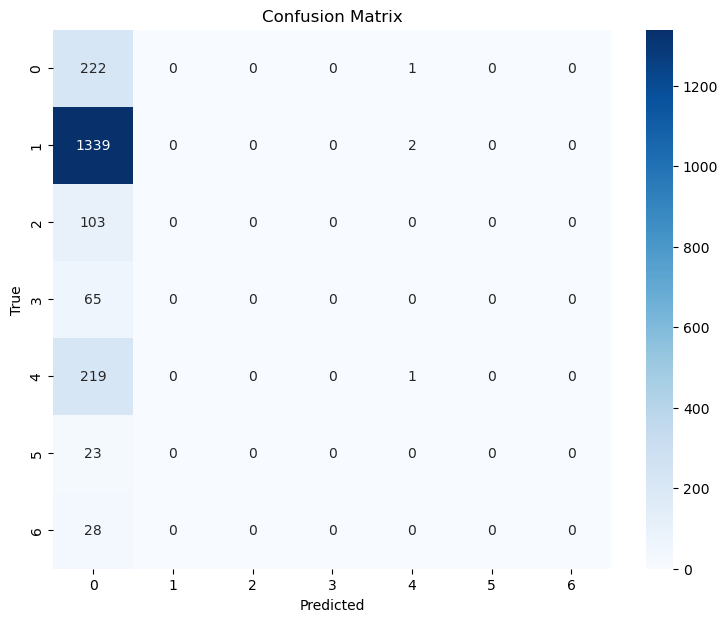

              precision    recall  f1-score   support

           0       0.11      1.00      0.20       223
           1       0.00      0.00      0.00      1341
           2       0.00      0.00      0.00       103
           3       0.00      0.00      0.00        65
           4       0.25      0.00      0.01       220
           5       0.00      0.00      0.00        23
           6       0.00      0.00      0.00        28

    accuracy                           0.11      2003
   macro avg       0.05      0.14      0.03      2003
weighted avg       0.04      0.11      0.02      2003



In [56]:
val_steps = int(np.ceil(val_generator.samples / BATCH_SIZE))
val_preds = model.predict(val_generator, steps=val_steps)
val_pred_indices = np.argmax(val_preds, axis=1)
val_true = val_generator.classes

index_to_class = {v:k for k,v in val_generator.class_indices.items()}
ordered_class_names = [index_to_class[i] for i in range(len(index_to_class))]

cm = confusion_matrix(val_true, val_pred_indices)
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=ordered_class_names, yticklabels=ordered_class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(val_true, val_pred_indices, target_names=ordered_class_names, zero_division=0))

In [57]:
# Plot training and validation curves

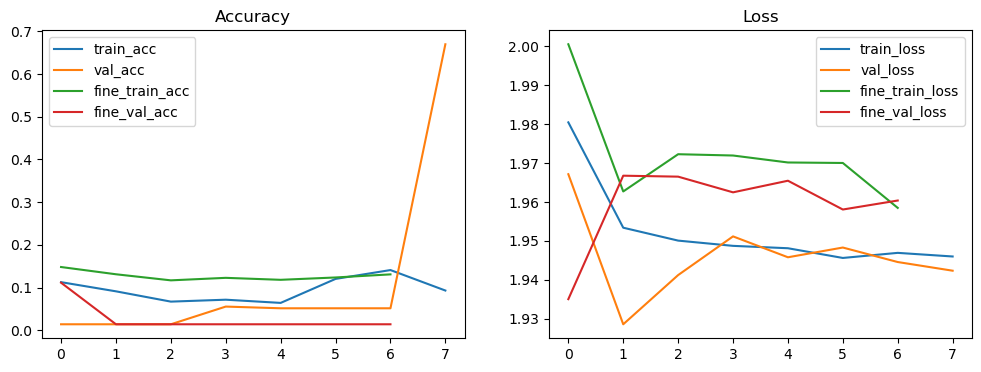

In [58]:
def plot_history(h1, h2=None):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(h1.history['accuracy'], label='train_acc')
    plt.plot(h1.history['val_accuracy'], label='val_acc')
    if h2 is not None:
        plt.plot(h2.history.get('accuracy', []), label='fine_train_acc')
        plt.plot(h2.history.get('val_accuracy', []), label='fine_val_acc')
    plt.legend()
    plt.title('Accuracy')
    plt.subplot(1,2,2)
    plt.plot(h1.history['loss'], label='train_loss')
    plt.plot(h1.history['val_loss'], label='val_loss')
    if h2 is not None:
        plt.plot(h2.history.get('loss', []), label='fine_train_loss')
        plt.plot(h2.history.get('val_loss', []), label='fine_val_loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

plot_history(history, history_fine)